<a href="https://colab.research.google.com/github/tlysenko/KyivstarBigDataSchool-studies/blob/master/Binary_classification_with_Catboost_at_LandingClub_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classfication task using Catboost algorithm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

## Installing the packages and importing the libraries

In [0]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

## Data preprocessing

In [0]:
df = pd.read_csv("/content/drive/My Drive/Datasets/DR_Demo_Lending_Club_reduced.csv", na_values='na')

In [0]:
df.head()

,Id,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,10.0,MORTGAGE,50000.0,not verified,n,medical,766xx,TX,10.87,0.0,0.0,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,1.0,RENT,39216.0,not verified,n,debt consolidation,660xx,KS,9.15,0.0,2.0,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,4.0,RENT,65000.0,not verified,n,credit card,916xx,CA,11.24,0.0,0.0,NaN,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,10.0,MORTGAGE,57500.0,not verified,n,debt consolidation,124xx,NY,6.18,1.0,0.0,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,10.0,MORTGAGE,50004.0,VERIFIED - income,n,debt consolidation,439xx,OH,19.03,0.0,4.0,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


## Missing variables 

In [0]:
# Missing values proportion
df.isna().sum()/df.shape[0]

Id                             0.0000
is_bad                         0.0000
emp_length                     0.0250
home_ownership                 0.0000
annual_inc                     0.0001
verification_status            0.0000
pymnt_plan                     0.0000
purpose_cat                    0.0000
zip_code                       0.0000
addr_state                     0.0000
debt_to_income                 0.0000
delinq_2yrs                    0.0005
inq_last_6mths                 0.0005
mths_since_last_delinq         0.6316
mths_since_last_record         0.9160
open_acc                       0.0005
pub_rec                        0.0005
revol_bal                      0.0000
revol_util                     0.0026
total_acc                      0.0005
initial_list_status            0.0000
collections_12_mths_ex_med     0.0032
mths_since_last_major_derog    0.0000
policy_code                    0.0000
dtype: float64

In [0]:
df.isna().sum()/df.shape[0] > 0

Id                             False
is_bad                         False
emp_length                      True
home_ownership                 False
annual_inc                      True
verification_status            False
pymnt_plan                     False
purpose_cat                    False
zip_code                       False
addr_state                     False
debt_to_income                 False
delinq_2yrs                     True
inq_last_6mths                  True
mths_since_last_delinq          True
mths_since_last_record          True
open_acc                        True
pub_rec                         True
revol_bal                      False
revol_util                      True
total_acc                       True
initial_list_status            False
collections_12_mths_ex_med      True
mths_since_last_major_derog    False
policy_code                    False
dtype: bool

In [0]:
# List of columns with NA values
a = df.isna().sum()/df.shape[0] > 0
col_na = a[a.values].index.values
col_na

array(['emp_length', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med'],
      dtype=object)

In [0]:
for col in col_na:
  print(col, df[col].dtypes)

emp_length float64
annual_inc float64
delinq_2yrs float64
inq_last_6mths float64
mths_since_last_delinq float64
mths_since_last_record float64
open_acc float64
pub_rec float64
revol_util float64
total_acc float64
collections_12_mths_ex_med float64


mths_since_last_delinq and mths_since_last_record variables should be dropeed from the dataset due to 50%+ amount of NAs.

### Is there a linear correlation between numerical variables and target variable?

In [0]:
numeric_cols = []
for colname, coltype in zip(df.columns, df.dtypes):
  if coltype == 'float64' or coltype == 'int64':
    numeric_cols.append(colname)
print(numeric_cols)

['Id', 'is_bad', 'emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog']


In [0]:
#numeric_cols.remove('is_bad')

In [0]:
dfcorr = df.loc[: , numeric_cols ].corr()
dfcorr

,Id,is_bad,emp_length,annual_inc,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog
Id,1.000000,0.010883,0.026633,0.002736,0.014795,-0.000116,0.015789,0.010847,-0.001643,0.016304,-0.002248,0.007223,0.014310,0.022924,NaN,-0.004367
is_bad,0.010883,1.000000,-0.023712,-0.050975,0.029873,0.021842,-0.001146,0.001358,0.135735,-0.020356,0.032174,-0.016202,0.087876,-0.055307,NaN,0.015481
emp_length,0.026633,-0.023712,1.000000,0.146692,0.058695,0.023947,-0.017866,0.070826,0.288704,0.100870,0.057232,0.110264,0.019488,0.212535,NaN,0.002579
annual_inc,0.002736,-0.050975,0.146692,1.000000,-0.130184,0.038670,0.056718,-0.024578,0.006997,0.233821,-0.010398,0.359817,0.030792,0.329146,NaN,-0.002476
debt_to_income,0.014795,0.029873,0.058695,-0.130184,1.000000,-0.034393,0.012819,0.057264,0.135642,0.301003,-0.005351,0.163794,0.271439,0.233594,NaN,-0.007031
delinq_2yrs,-0.000116,0.021842,0.023947,0.038670,-0.034393,1.000000,0.039215,-0.532198,-0.051665,0.027398,0.020411,-0.030090,-0.051301,0.081918,NaN,-0.002744
inq_last_6mths,0.015789,-0.001146,-0.017866,0.056718,0.012819,0.039215,1.000000,-0.023393,-0.185354,0.088105,0.054711,0.043130,-0.037232,0.084671,NaN,0.008570
mths_since_last_delinq,0.010847,0.001358,0.070826,-0.024578,0.057264,-0.532198,-0.023393,1.000000,0.463951,0.036954,0.041267,-0.027052,0.094004,0.033914,NaN,-0.004022
mths_since_last_record,-0.001643,0.135735,0.288704,0.006997,0.135642,-0.051665,-0.185354,0.463951,1.000000,0.079317,0.784052,-0.063885,0.141067,0.153136,NaN,-0.027471
open_acc,0.016304,-0.020356,0.100870,0.233821,0.301003,0.027398,0.088105,0.036954,0.079317,1.000000,0.006680,0.233842,-0.074018,0.695387,NaN,-0.006169


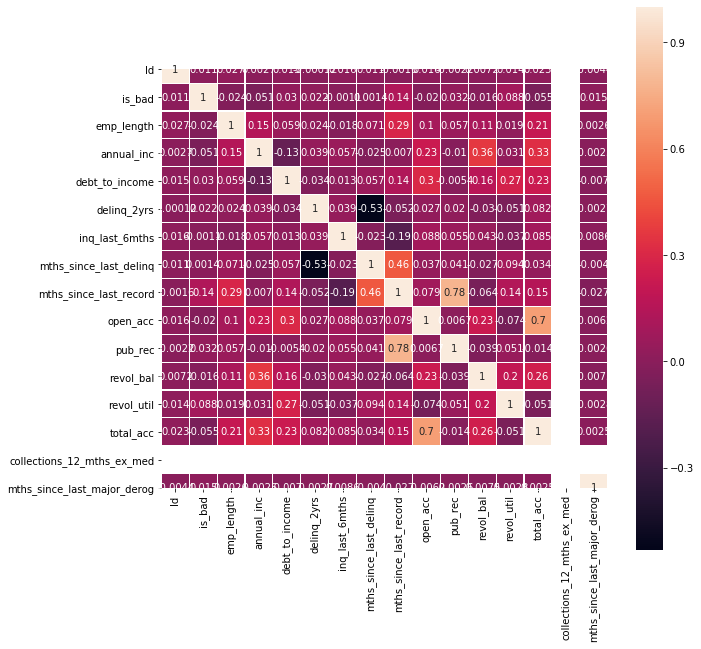

In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(dfcorr,linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

As long as there is no correllation between the **emp_length, revol_util, total_acc** variables and the target one we can replace NAN values with mean value. 

**collections_12_mths_ex_med** variable should be dropped off as long as it contains either zero or NAN values.

In [0]:
for col in col_na:
  mean_value = np.mean(df[col])
  df[col] = df[col].fillna(value = mean_value)

In [0]:
df = df.drop(['collections_12_mths_ex_med', 'Id', 'mths_since_last_delinq', 'mths_since_last_record'], axis = 1)

## Dummy encoding text/categorical features

In [0]:
categorical_variables = []
for colname, coltype in zip(df.columns, df.dtypes):
  if coltype == object:
    print(colname, coltype)
    categorical_variables.append(colname)

home_ownership object
verification_status object
pymnt_plan object
purpose_cat object
zip_code object
addr_state object
initial_list_status object
policy_code object


In [0]:
categorical_variables

['home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose_cat',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'policy_code']

In [0]:
df = pd.concat([df,pd.get_dummies(df[categorical_variables])], axis = 1)
df = df.drop(categorical_variables, axis =1) 

## Model training

In [0]:
catboost = CatBoostRegressor(task_type ='GPU', random_seed=111)

In [0]:
X = df.drop('is_bad', axis=1)
y = df['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [0]:
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [0]:
catboost.fit(X_train, y_train, verbose=False)

## Prediction

In [0]:
prediction = catboost.predict(X_test)
prediction = [int(round(x,0)) for x in prediction]

## Model evaluation

In [0]:
roc_auc_score(y_test, prediction)

0.5752895752895753

In [0]:
accuracy_score(y_test, prediction)

0.89

In [0]:
confusion_matrix(y_test, prediction)

array([[1741,    0],
       [ 220,   39]])

In [0]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1741
           1       1.00      0.15      0.26       259

    accuracy                           0.89      2000
   macro avg       0.94      0.58      0.60      2000
weighted avg       0.90      0.89      0.85      2000



## Summary

The model has 1.0 percision for the '1' class that means the bank will operate in the a very low risk mode by granding the credits only to the clients that would surely give it back. 

Next steps: 
* Parameters tuning using Grid Search CV with Cross Validation

## Feature importance

In [0]:
# The plot is not working in collab, unforunately
res = catboost.calc_feature_statistics(X_train,
                                        y_train,
                                        feature=2,
                                        plot=True)